# Paris neighbourhoods and suburbs exploration and clustering
This Notebook aims at exploring and clustering the Parisian neighbourhoods and suburbs with respect to the venues information available through Foursquare.

### Data Import and Preprocessing

First, let us import all the necessary libraries we'll be using for the study.

In [1]:
import sys

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import yellowbrick to apply and visualize the elbow method
from yellowbrick.cluster import KElbowVisualizer

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


Import the zip codes data previously downloaded from the French governmental web site: https://www.data.gouv.fr/fr/datasets/base-officielle-des-codes-postaux/

In [2]:
zipc = pd.read_csv('laposte_hexasmal.csv',header=0, sep=';')
zipc.head()

,Code_commune_INSEE,Nom_commune,Code_postal,Ligne_5,Libellé_d_acheminement,coordonnees_gps
0,25628,VILLERS SOUS MONTROND,25620,NaN,VILLERS SOUS MONTROND,"47.1453733993,6.08965365162"
1,26001,SOLAURE EN DIOIS,26150,AIX EN DIOIS,SOLAURE EN DIOIS,"44.7024063065,5.38335100127"
2,26001,SOLAURE EN DIOIS,26150,MOLIERES GLANDAZ,SOLAURE EN DIOIS,"44.7024063065,5.38335100127"
3,26006,ALLEX,26400,NaN,ALLEX,"44.7665515552,4.91520351074"
4,26013,ARPAVON,26110,NaN,ARPAVON,"44.370914993,5.27351034083"


The GPS coordinates are stored in one column, because they had a different separator. Thus, ze split the coordinates column into two. This table also has many columns that we won't need, so we get rid of them and rename the others.

In [3]:
zipc['Latitude'], zipc['Longitude'] = zipc['coordonnees_gps'].str.split(',', 1).str
zipc.drop(['Code_commune_INSEE', 'Ligne_5', 'Libellé_d_acheminement', 'coordonnees_gps'], axis=1, inplace = True)
zipc.rename(columns = {'Nom_commune':'Name', 'Code_postal':'Zip_Code'}, inplace = True)
zipc.head()

,Name,Zip_Code,Latitude,Longitude
0,VILLERS SOUS MONTROND,25620,47.1453733993,6.08965365162
1,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127
2,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127
3,ALLEX,26400,44.7665515552,4.91520351074
4,ARPAVON,26110,44.370914993,5.27351034083


The table now contains only the necessary columns, but it still has too many rows: we downloaded wip codes for the whole France, whereas we will only be studying the Paris region. The region (or department in French to be precise) of a town or a neighbourhood is coded in the first two digits of its zip code, so let's extract those and add them to our table a new column.

In [4]:
def get_dep_num(zip_code): # function to extract the first two digits from a zip code
    s_code = str(zip_code)
    if len(s_code) < 5:
        s_code = '0' + s_code
    return int(s_code[0:2])

In [5]:
zipc['Department'] = zipc['Zip_Code'].apply(get_dep_num)
zipc.head()

,Name,Zip_Code,Latitude,Longitude,Department
0,VILLERS SOUS MONTROND,25620,47.1453733993,6.08965365162,25
1,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127,26
2,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127,26
3,ALLEX,26400,44.7665515552,4.91520351074,26
4,ARPAVON,26110,44.370914993,5.27351034083,26


The so called "Petite Couronne" of Paris consists of four departments: Paris intself (code 75), Hauts-de-Seine (code 92), Seine-Saint-Denis (93), and Val-de-Marne (94). Let's only choose the towns and boroughs in these departments.

In [6]:
# The Petite Couronne
paris_region_num = [75, 92, 93, 94]

In [7]:
zip_paris = zipc[zipc['Department'].isin(paris_region_num)] # choose only the Paris region departments
zip_paris = zip_paris.reset_index()
zip_paris.drop(['index'], axis=1, inplace = True)
zip_paris.drop_duplicates(subset = ['Name'], inplace = True) # drop duplicates (due to the input file)
print('Number of Towns and Boroughs: ' + str(zip_paris.shape[0]))
zip_paris.sort_values(by = 'Name')

Number of Towns and Boroughs: 144


,Name,Zip_Code,Latitude,Longitude,Department
23,ABLON SUR SEINE,94480,48.7238409464,2.42117629348,94
59,ALFORTVILLE,94140,48.7960843864,2.42124593241,94
96,ANTONY,92160,48.7503412602,2.2993268102,92
86,ARCUEIL,94110,48.8058803597,2.33351024984,94
97,ASNIERES SUR SEINE,92600,48.9153530123,2.2880384663,92
131,AUBERVILLIERS,93300,48.9121722626,2.38445513768,93
77,AULNAY SOUS BOIS,93600,48.9458384367,2.49329041687,93
70,BAGNEUX,92220,48.7983229866,2.30989995212,92
132,BAGNOLET,93170,48.8690836308,2.42274096688,93
54,BOBIGNY,93000,48.907688244,2.43863982727,93


### Foursquare data exploration
Connect to the Foursquare database

In [8]:
CLIENT_ID = 'LJZO500UG2WRLMIB3X3TAJLLZVKQURND3DXC3IARUPROJDZF' # my Foursquare ID
CLIENT_SECRET = 'Z5NKNMAJWV4JJKKB00PPALKOGREH4NPQYAMRMQOMXBQYAPEW' # my Foursquare Secret
VERSION = '20200627' # Foursquare API version today

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LJZO500UG2WRLMIB3X3TAJLLZVKQURND3DXC3IARUPROJDZF
CLIENT_SECRET:Z5NKNMAJWV4JJKKB00PPALKOGREH4NPQYAMRMQOMXBQYAPEW


Create functions for requesting the Foursquare database

In [9]:
def get_venues(name, lat, lng, radius, limit):  
    print(name)
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    # make the GET request
    raw = requests.get(url).json()
    results = None
    try:
        results = raw["response"]['groups'][0]['items']
    except:
        print(f"A problem occured with parsing {raw} ")
    # return only relevant information for each nearby venue
    return results

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        results = get_venues(name, lat, lng, radius, limit)
        if not results:
            continue
        venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
              'Neighbourhood Latitude', 
              'Neighbourhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

    return(nearby_venues)

Set the maximal number of venues to charge (LIMIT) and the radius to search in meters (radius)

In [11]:
LIMIT = 100
radius = 1000

Get the venues for each of the boroughs

In [12]:
paris_venues = getNearbyVenues(names=zip_paris['Name'],
                               latitudes=zip_paris['Latitude'],
                               longitudes=zip_paris['Longitude'],
                               radius=radius, limit=LIMIT
                               )

PARIS 04
PARIS 07
PARIS 11
PARIS 15
A problem occured with parsing {'meta': {'code': 500, 'errorType': 'server_error', 'errorDetail': 'Foursquare servers are experiencing problems. Please retry and check status.foursquare.com for updates.'}, 'response': {}} 
PARIS 16
PARIS 20
BOIS COLOMBES
BOULOGNE BILLANCOURT
CHAVILLE
COURBEVOIE
LA GARENNE COLOMBES
LEVALLOIS PERRET
MALAKOFF
RUEIL MALMAISON
SCEAUX
SEVRES
LE BOURGET
COUBRON
MONTFERMEIL
NEUILLY SUR MARNE
PANTIN
LES PAVILLONS SOUS BOIS
VAUJOURS
ABLON SUR SEINE
CHAMPIGNY SUR MARNE
CHENNEVIERES SUR MARNE
FONTENAY SOUS BOIS
L HAY LES ROSES
JOINVILLE LE PONT
MAISONS ALFORT
ST MANDE
ST MAUR DES FOSSES
SUCY EN BRIE
VILLENEUVE ST GEORGES
PARIS 06
PARIS 12
PARIS 13
PARIS 18
PARIS 01
PARIS 05
PARIS 09
PARIS 10
PARIS 02
PARIS 03
PARIS 08
PARIS 14
A problem occured with parsing {'meta': {'code': 500, 'errorType': 'server_error', 'errorDetail': 'Foursquare servers are experiencing problems. Please retry and check status.foursquare.com for updates.'},

In [13]:
print('Number of venues:' + str(paris_venues.shape[0]))
paris_venues.head()

Number of venues:4211


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PARIS 04,48.854228282,2.35736193814,Aux Merveilleux de Fred,48.855686,2.356369,Dessert Shop
1,PARIS 04,48.854228282,2.35736193814,Chez Mademoiselle,48.854290,2.359810,Restaurant
2,PARIS 04,48.854228282,2.35736193814,Jardin de l'Hôtel de Sens,48.853842,2.358404,Garden
3,PARIS 04,48.854228282,2.35736193814,Maison Européenne de la Photographie,48.855128,2.358948,Art Museum
4,PARIS 04,48.854228282,2.35736193814,Le Peloton Café,48.855505,2.356034,Coffee Shop


In [14]:
venues_per_neighb = paris_venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count()
venues_per_neighb

,Venue
Neighbourhood,
ABLON SUR SEINE,4
ALFORTVILLE,22
ANTONY,16
ARCUEIL,26
ASNIERES SUR SEINE,36
AUBERVILLIERS,18
AULNAY SOUS BOIS,15
BAGNEUX,14
BAGNOLET,21


The total number of venues varies from just a couple of venues for the smallest towns up to the maximal limit chosen in the beginning.

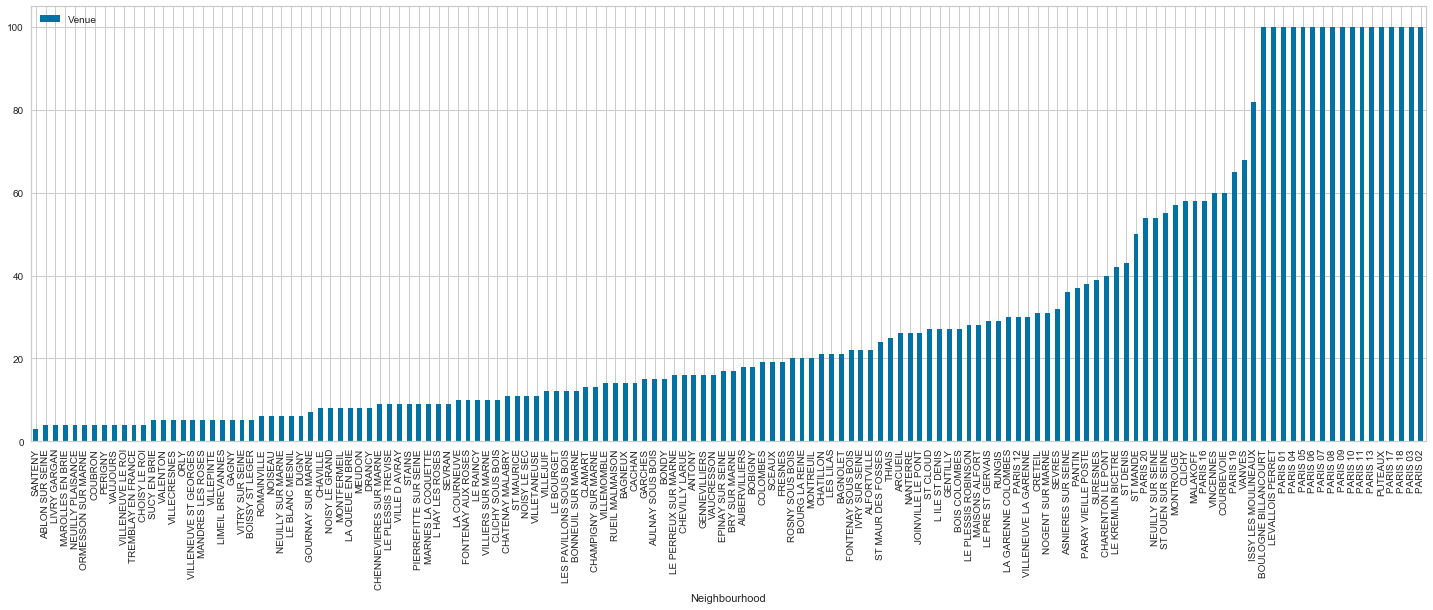

In [15]:
venues_per_neighb.sort_values(by='Venue').plot.bar(figsize=(25,8))
# plt.savefig('hist.png')

Let's select for the further study only the boroughs having 10 venues or more.

In [16]:
selected_venues = venues_per_neighb.Venue[venues_per_neighb.Venue >= 10]

In [17]:
sel_paris_venues = paris_venues[paris_venues['Neighbourhood'].isin(set(selected_venues.index))]
print(sel_paris_venues.shape)
sel_paris_venues.head()

(3952, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PARIS 04,48.854228282,2.35736193814,Aux Merveilleux de Fred,48.855686,2.356369,Dessert Shop
1,PARIS 04,48.854228282,2.35736193814,Chez Mademoiselle,48.854290,2.359810,Restaurant
2,PARIS 04,48.854228282,2.35736193814,Jardin de l'Hôtel de Sens,48.853842,2.358404,Garden
3,PARIS 04,48.854228282,2.35736193814,Maison Européenne de la Photographie,48.855128,2.358948,Art Museum
4,PARIS 04,48.854228282,2.35736193814,Le Peloton Café,48.855505,2.356034,Coffee Shop


In [18]:
venues_per_neighb.Venue[venues_per_neighb.Venue >= 10].count()

99

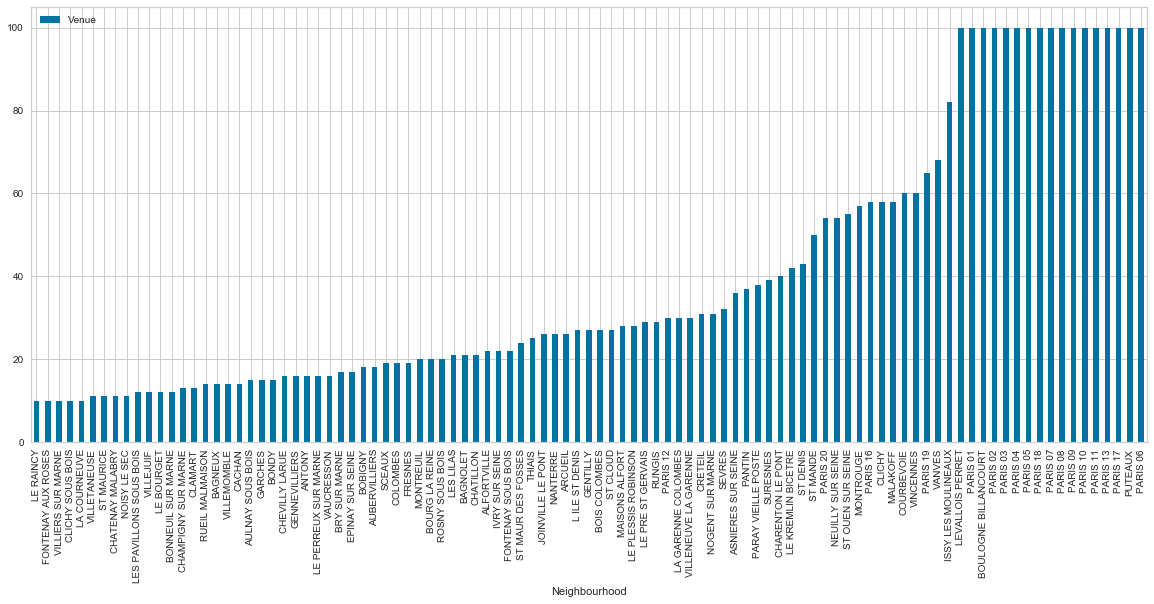

In [19]:
sel_paris_venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count().sort_values(by='Venue').plot.bar(figsize=(20,8))

### Clustering
Prepare the features set

In [20]:
# one hot encoding
paris_onehot = pd.get_dummies(sel_paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighbourhood'] = sel_paris_venues['Neighbourhood'] 

# move neighborhood column to the first column
# get a list of columns
fixed_columns = list(paris_onehot)
# move the column to head of list using index, pop and insert
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighbourhood')))
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Car Wash,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Donut Shop,Drive-in Theater,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Pakistani Restaurant,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Roof Deck,Rugby Pitch,Rugby Stadium,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,S

In [21]:
print('There are {} unique categories.'.format(len(sel_paris_venues['Venue Category'].unique())))

There are 320 unique categories.


In [22]:
paris_grouped = paris_onehot.groupby('Neighbourhood').mean().reset_index()
paris_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Car Wash,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Donut Shop,Drive-in Theater,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Pakistani Restaurant,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Roof Deck,Rugby Pitch,Rugby Stadium,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,S

Take a look at the top five venues for each borough

In [23]:
num_top_venues = 5

for hood in paris_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALFORTVILLE----
                    venue  freq
0                Bus Stop  0.14
1    Fast Food Restaurant  0.09
2        Asian Restaurant  0.09
3                 Theater  0.05
4  Furniture / Home Store  0.05


----ANTONY----
               venue  freq
0  French Restaurant  0.19
1        Supermarket  0.12
2        Pizza Place  0.06
3               Park  0.06
4      Train Station  0.06


----ARCUEIL----
              venue  freq
0    Clothing Store  0.08
1             Hotel  0.08
2    Sandwich Place  0.08
3  Sushi Restaurant  0.08
4       Supermarket  0.08


----ASNIERES SUR SEINE----
                 venue  freq
0  Japanese Restaurant  0.08
1               Market  0.06
2              Theater  0.06
3                Hotel  0.06
4          Supermarket  0.06


----AUBERVILLIERS----
                  venue  freq
0          Soccer Field  0.11
1     French Restaurant  0.11
2  Gym / Fitness Center  0.11
3            Canal Lock  0.06
4              Bus Stop  0.06


----AULNAY SOUS BOIS----
 

4             Bakery  0.07


----LE PRE ST GERVAIS----
               venue  freq
0  French Restaurant  0.17
1              Hotel  0.10
2        Supermarket  0.07
3      Movie Theater  0.07
4         Restaurant  0.03


----LE RAINCY----
              venue  freq
0       Supermarket   0.2
1  Sushi Restaurant   0.1
2            Market   0.1
3  Asian Restaurant   0.1
4     Train Station   0.1


----LES LILAS----
                  venue  freq
0                  Park  0.10
1          Tennis Court  0.05
2  Fast Food Restaurant  0.05
3      Sushi Restaurant  0.05
4            Distillery  0.05


----LES PAVILLONS SOUS BOIS----
                  venue  freq
0      Sushi Restaurant  0.17
1    Light Rail Station  0.17
2   Moroccan Restaurant  0.08
3   Sporting Goods Shop  0.08
4  Fast Food Restaurant  0.08


----LEVALLOIS PERRET----
               venue  freq
0  French Restaurant  0.11
1        Supermarket  0.07
2              Hotel  0.06
3             Bistro  0.04
4        Pizza Place  0.04


--

               venue  freq
0  French Restaurant  0.13
1             Bakery  0.09
2              Hotel  0.07
3        Supermarket  0.05
4                Bar  0.05


----SURESNES----
                 venue  freq
0    French Restaurant  0.10
1                  Pub  0.05
2                Hotel  0.05
3  Japanese Restaurant  0.05
4          Pizza Place  0.05


----THIAIS----
                    venue  freq
0                Bus Stop  0.16
1       Electronics Store  0.08
2  Furniture / Home Store  0.08
3          Clothing Store  0.08
4             Coffee Shop  0.04


----VANVES----
                 venue  freq
0    French Restaurant  0.13
1          Pizza Place  0.09
2  Japanese Restaurant  0.06
3          Supermarket  0.06
4                Hotel  0.06


----VAUCRESSON----
               venue  freq
0  French Restaurant  0.12
1           Creperie  0.06
2     Farmers Market  0.06
3        Rugby Pitch  0.06
4        Supermarket  0.06


----VILLEJUIF----
               venue  freq
0        Superm

In [24]:
def return_most_common_venues(row, num_top_venues): #function defining the top venues
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = paris_grouped['Neighbourhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALFORTVILLE,Bus Stop,Fast Food Restaurant,Asian Restaurant,Pool,Train Station,Middle Eastern Restaurant,Brasserie,Big Box Store,Flower Shop,Steakhouse
1,ANTONY,French Restaurant,Supermarket,Farmers Market,Airport Tram,Restaurant,Park,Train Station,Bakery,Spanish Restaurant,Fast Food Restaurant
2,ARCUEIL,Sandwich Place,Sushi Restaurant,Hotel,Supermarket,Clothing Store,Bus Stop,Garden,Asian Restaurant,Arts & Crafts Store,Movie Theater
3,ASNIERES SUR SEINE,Japanese Restaurant,Market,Hotel,French Restaurant,Theater,Supermarket,Cafeteria,Diner,Discount Store,Salon / Barbershop
4,AUBERVILLIERS,Soccer Field,French Restaurant,Gym / Fitness Center,Park,Fast Food Restaurant,Supermarket,Basketball Stadium,Bakery,Bus Stop,Gas Station
5,AULNAY SOUS BOIS,Hotel,Fast Food Restaurant,Supermarket,Gas Station,Pet Store,Asian Restaurant,Park,Bus Stop,Pizza Place,Comedy Club
6,BAGNEUX,Bus Stop,Japanese Restaurant,Plaza,Gas Station,Gym / Fitness Center,Bakery,Sandwich Place,Farmers Market,Pool,Eastern European Restaurant
7,BAGNOLET,Park,French Restaurant,Fast Food Restaurant,Hotel,Electronics Store,Supermarket,Bar,Bakery,Sandwich Place,Furniture / Home Store
8,BOBIGNY,Supermarket,Fast Food Restaurant,Mobile Phone Shop,Big Box Store,Italian Restaurant,Other Repair Shop,Stadium,Creperie,Performing Arts Venue,Tram Station
9,BOIS COLOMBES,Supermarket,Bakery,Japanese Restaurant,Martial Arts Dojo,Train Station,Nail Salon,French Restaurant,Stadium,Italian Restaurant,Creperie


In [26]:
paris_grouped_clustering = paris_grouped.drop(['Neighbourhood'], axis = 1)

C:\Users\mrzay\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\mrzay\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


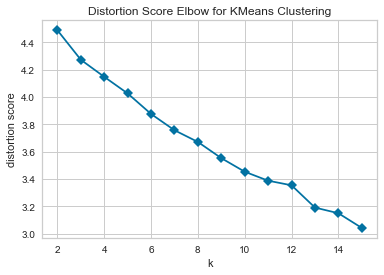

In [27]:
model = KElbowVisualizer(KMeans(random_state=0), k=15, timings=False)
model.fit(paris_grouped_clustering)
model.show()

In [28]:
# set number of clusters
kclusters = 5 # model_supercat.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 1, 2, 4, 4, 4, 2, 4, 4, 0, 0, 2, 1, 2, 0, 2, 4, 3, 2, 4, 3, 4,
       3, 2, 4, 3, 2, 4, 0, 4, 0, 0, 4, 2, 1, 2, 4, 4, 4, 1, 4, 4, 1, 4,
       3, 0, 2, 0, 1, 4, 1, 4, 4, 2, 1, 0, 4, 4, 2, 1, 1, 2, 1, 1, 1, 3,
       3, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 4, 4, 3, 2, 4, 1, 4, 1, 0, 4,
       1, 1, 2, 1, 1, 0, 4, 4, 0, 0, 1])

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = zip_paris

# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), \
                                                   on='Name', how='right')

paris_merged # check the last columns!

,Name,Zip_Code,Latitude,Longitude,Department,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PARIS 04,75004,48.854228282,2.35736193814,75,1,French Restaurant,Plaza,Ice Cream Shop,Wine Bar,Cocktail Bar,Hotel,Restaurant,Furniture / Home Store,Bakery,Scandinavian Restaurant
1,PARIS 07,75007,48.8560825982,2.31243868773,75,3,French Restaurant,Hotel,Plaza,Italian Restaurant,Coffee Shop,Historic Site,Garden,Café,Cocktail Bar,History Museum
2,PARIS 11,75011,48.8594154976,2.37874106024,75,1,French Restaurant,Restaurant,Bistro,Bar,Bakery,Wine Bar,Pizza Place,Italian Restaurant,Café,Cocktail Bar
4,PARIS 16,75116,48.8603987604,2.2620995594,75,1,French Restaurant,Bakery,Italian Restaurant,Park,Lake,Plaza,Japanese Restaurant,Garden,Art Museum,Hotel
5,PARIS 20,75020,48.8631867774,2.40081982673,75,1,Bar,French Restaurant,Bakery,Bistro,Café,Music Venue,Theater,Moroccan Restaurant,Beer Bar,Roof Deck
6,BOIS COLOMBES,92270,48.9153368426,2.26738552597,92,0,Supermarket,Bakery,Japanese Restaurant,Martial Arts Dojo,Train Station,Nail Salon,French Restaurant,Stadium,Italian Restaurant,Creperie
7,BOULOGNE BILLANCOURT,92100,48.8365843138,2.23913599058,92,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Bakery,Burger Joint,Kebab Restaurant,Plaza,Pizza Place,Market,Restaurant
9,COURBEVOIE,92400,48.8984504771,2.25570587289,92,3,Hotel,French Restaurant,Supermarket,Stadium,Italian Restaurant,Plaza,Japanese Restaurant,Farmers Market,Pizza Place,Bakery
10,LA GARENNE COLOMBES,92250,48.9067577111,2.24464604084,92,1,Japanese Restaurant,French Restaurant,Creperie,Pizza Place,Plaza,Market,Korean Restaurant,Bakery,Dessert Shop,Café
11,LEVALLOIS PERRET,92300,48.895071672,2.28688268127,92,1,French Restaurant,Supermarket,Hotel,Sandwich Place,Bistro,Pizza Place,Bar,Park,Clothing Store,Farmers Market


In [30]:
latitude = paris_merged.loc[paris_merged['Name']=='PARIS 01','Latitude'].astype(float)
longitude = paris_merged.loc[paris_merged['Name']=='PARIS 01','Longitude'].astype(float)

# create map
map_clusters = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'].astype(float), paris_merged['Longitude'].astype(float), \
                                  paris_merged['Name'], paris_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Yellowbrick is either unable to detect an elbow on these data, or detects one that is not evident at all. This means that the data do not represent distinct clusters. My hypothesis is that this issue can be treated by regrouping the venue categories into much bigger super-categories, for example, 'Burgundian Restaurant', 'Savoyard Restaurant', and 'Breton Restaurant' would all go the 'French Restaurant' super category.

In [31]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,BOIS COLOMBES,0,Supermarket,Bakery,Japanese Restaurant,Martial Arts Dojo,Train Station,Nail Salon,French Restaurant,Stadium,Italian Restaurant,Creperie
21,LES PAVILLONS SOUS BOIS,0,Light Rail Station,Sushi Restaurant,Supermarket,Fast Food Restaurant,Moroccan Restaurant,Chinese Restaurant,Auto Garage,Sporting Goods Shop,Canal,Restaurant
31,ST MAUR DES FOSSES,0,Supermarket,Sushi Restaurant,Café,Garden,Train Station,Brasserie,Food & Drink Shop,French Restaurant,Bar,Bakery
58,VILLETANEUSE,0,Supermarket,Tram Station,Furniture / Home Store,Bakery,Light Rail Station,Shopping Mall,Miscellaneous Shop,Soccer Field,Event Space,Ethiopian Restaurant
78,BONDY,0,Fast Food Restaurant,Supermarket,Middle Eastern Restaurant,Electronics Store,Bank,Light Rail Station,Eastern European Restaurant,Canal,Train Station,Steakhouse
81,LE RAINCY,0,Supermarket,Bistro,Train Station,Market,Sushi Restaurant,Asian Restaurant,Japanese Restaurant,Italian Restaurant,Optical Shop,Corsican Restaurant
87,BRY SUR MARNE,0,Supermarket,Stadium,Bakery,Asian Restaurant,Italian Restaurant,Train Station,Recreation Center,Greek Restaurant,Café,French Restaurant
100,FONTENAY AUX ROSES,0,Supermarket,Italian Restaurant,Theater,Hotel,Brasserie,Movie Theater,Martial Arts Dojo,Bus Stop,Park,Zoo Exhibit
101,GARCHES,0,Café,Golf Course,Farmers Market,Smoke Shop,Shopping Mall,Supermarket,Bakery,Restaurant,Italian Restaurant,Train Station
116,NOGENT SUR MARNE,0,Supermarket,Bowling Alley,Hotel,Bar,Restaurant,Train Station,Bakery,Food & Drink Shop,Italian Restaurant,Asian Restaurant


In [32]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PARIS 04,1,French Restaurant,Plaza,Ice Cream Shop,Wine Bar,Cocktail Bar,Hotel,Restaurant,Furniture / Home Store,Bakery,Scandinavian Restaurant
2,PARIS 11,1,French Restaurant,Restaurant,Bistro,Bar,Bakery,Wine Bar,Pizza Place,Italian Restaurant,Café,Cocktail Bar
4,PARIS 16,1,French Restaurant,Bakery,Italian Restaurant,Park,Lake,Plaza,Japanese Restaurant,Garden,Art Museum,Hotel
5,PARIS 20,1,Bar,French Restaurant,Bakery,Bistro,Café,Music Venue,Theater,Moroccan Restaurant,Beer Bar,Roof Deck
7,BOULOGNE BILLANCOURT,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Bakery,Burger Joint,Kebab Restaurant,Plaza,Pizza Place,Market,Restaurant
10,LA GARENNE COLOMBES,1,Japanese Restaurant,French Restaurant,Creperie,Pizza Place,Plaza,Market,Korean Restaurant,Bakery,Dessert Shop,Café
11,LEVALLOIS PERRET,1,French Restaurant,Supermarket,Hotel,Sandwich Place,Bistro,Pizza Place,Bar,Park,Clothing Store,Farmers Market
12,MALAKOFF,1,Supermarket,French Restaurant,Japanese Restaurant,Pizza Place,Bakery,Farmers Market,Bus Stop,Sushi Restaurant,Italian Restaurant,Park
30,ST MANDE,1,French Restaurant,Japanese Restaurant,Italian Restaurant,Bakery,Supermarket,Plaza,Asian Restaurant,Sandwich Place,Bike Rental / Bike Share,Bistro
34,PARIS 06,1,French Restaurant,Hotel,Plaza,Garden,Bistro,Ice Cream Shop,Wine Bar,Bookstore,Chocolate Shop,Creperie


In [33]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,SCEAUX,2,Café,Garden,Italian Restaurant,Historic Site,Park,Bakery,Canal,Candy Store,Market,Castle
36,PARIS 13,2,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Chinese Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Gym / Fitness Center
43,PARIS 03,2,French Restaurant,Coffee Shop,Art Gallery,Cocktail Bar,Hotel,Restaurant,Burger Joint,Japanese Restaurant,Sandwich Place,Bookstore
52,NANTERRE,2,Basketball Stadium,Restaurant,Hotel,Park,Asian Restaurant,Coffee Shop,French Restaurant,Bakery,Supermarket,Music Venue
55,LES LILAS,2,Park,Indian Restaurant,Garden,Distillery,Tennis Court,Tennis Stadium,Japanese Restaurant,Italian Restaurant,Toy / Game Store,Irish Pub
59,ALFORTVILLE,2,Bus Stop,Fast Food Restaurant,Asian Restaurant,Pool,Train Station,Middle Eastern Restaurant,Brasserie,Big Box Store,Flower Shop,Steakhouse
60,CACHAN,2,Fast Food Restaurant,Park,Sandwich Place,Bus Stop,Farmers Market,Athletics & Sports,Theater,Arts & Crafts Store,Japanese Restaurant,Bakery
62,CRETEIL,2,Bus Stop,Clothing Store,Hotel,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,BBQ Joint,Asian Restaurant,Sandwich Place,Supermarket
63,GENTILLY,2,Park,Bakery,Hotel,Burger Joint,Café,Football Stadium,Food Truck,Bus Stop,Brasserie,Stadium
70,BAGNEUX,2,Bus Stop,Japanese Restaurant,Plaza,Gas Station,Gym / Fitness Center,Bakery,Sandwich Place,Farmers Market,Pool,Eastern European Restaurant


In [34]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,PARIS 07,3,French Restaurant,Hotel,Plaza,Italian Restaurant,Coffee Shop,Historic Site,Garden,Café,Cocktail Bar,History Museum
9,COURBEVOIE,3,Hotel,French Restaurant,Supermarket,Stadium,Italian Restaurant,Plaza,Japanese Restaurant,Farmers Market,Pizza Place,Bakery
40,PARIS 09,3,French Restaurant,Hotel,Wine Bar,Italian Restaurant,Cocktail Bar,Bar,Coffee Shop,Pizza Place,Concert Hall,Cheese Shop
44,PARIS 08,3,Hotel,French Restaurant,Garden,Theater,Art Gallery,Tailor Shop,Clothing Store,Sporting Goods Shop,Bakery,Spa
47,PARIS 17,3,French Restaurant,Italian Restaurant,Hotel,Bakery,Restaurant,Pastry Shop,Park,Mediterranean Restaurant,Japanese Restaurant,Bagel Shop
61,CHARENTON LE PONT,3,French Restaurant,Hotel,Bakery,Bus Stop,Gym / Fitness Center,Plaza,Chinese Restaurant,Food Truck,Basketball Court,Lake
66,RUNGIS,3,Hotel,French Restaurant,Tram Station,Sandwich Place,Food Truck,Japanese Restaurant,Seafood Restaurant,Restaurant,Park,Arepa Restaurant
111,LE PRE ST GERVAIS,3,French Restaurant,Hotel,Supermarket,Movie Theater,Gym / Fitness Center,Restaurant,Japanese Restaurant,Theater,Italian Restaurant,Wine Bar
113,CHEVILLY LARUE,3,Bus Stop,Hotel,French Restaurant,Tennis Court,Fast Food Restaurant,Bakery,Theater,Flower Shop,Food,Stadium
124,CLICHY,3,Hotel,Italian Restaurant,French Restaurant,Park,Gym,Japanese Restaurant,Restaurant,Bus Stop,Pizza Place,Supermarket


In [35]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,RUEIL MALMAISON,4,Supermarket,Soccer Field,Creperie,Castle,Gas Station,Grocery Store,Park,Farmers Market,French Restaurant,Hotel
15,SEVRES,4,Bistro,Japanese Restaurant,French Restaurant,Supermarket,Café,Bus Stop,Pharmacy,Tennis Court,Sushi Restaurant,Martial Arts Dojo
16,LE BOURGET,4,Park,Discount Store,Italian Restaurant,Bakery,Hotel,Construction & Landscaping,Pharmacy,Light Rail Station,Bus Station,Supermarket
20,PANTIN,4,Supermarket,French Restaurant,Art Gallery,Dance Studio,Market,Movie Theater,Sandwich Place,Auto Garage,Italian Restaurant,Fried Chicken Joint
24,CHAMPIGNY SUR MARNE,4,French Restaurant,Supermarket,Fast Food Restaurant,Smoke Shop,Bakery,Train Station,Food & Drink Shop,Skating Rink,Farmers Market,Hotel
26,FONTENAY SOUS BOIS,4,Pizza Place,Hotel,Fast Food Restaurant,Japanese Restaurant,Portuguese Restaurant,Perfume Shop,Restaurant,Cafeteria,Sandwich Place,Doner Restaurant
28,JOINVILLE LE PONT,4,Supermarket,Plaza,Bakery,Hotel,Pub,Intersection,Sushi Restaurant,French Restaurant,Beach,River
29,MAISONS ALFORT,4,Bus Stop,Japanese Restaurant,Supermarket,Pizza Place,Music School,Tennis Court,Italian Restaurant,Theater,Asian Restaurant,Flower Shop
49,CLAMART,4,French Restaurant,Cafeteria,Brewery,Gas Station,Forest,Supermarket,Tram Station,Perfume Shop,Performing Arts Venue,Gym / Fitness Center
50,GENNEVILLIERS,4,Tram Station,Fast Food Restaurant,Hotel,Gym,Metro Station,French Restaurant,Park,Arts & Crafts Store,Restaurant,Gas Station


In [36]:
big_cats_dict = {'Asian Restaurant':['Thai Restaurant','Asian Restaurant','Japanese Restaurant', 'Korean Restaurant',\
                                     'Vietnamese Restaurant','Chinese Restaurant', 'Sushi Restaurant','Ramen Restaurant', \
                                     'Cambodian Restaurant','Cantonese Restaurant', 'Udon Restaurant', \
                                     'Taiwanese Restaurant', 'Noodle House', 'Shanxi Restaurant', \
                                      'Okonomiyaki Restaurant', 'Szechuan Restaurant'],
                 'French Restaurant':['French Restaurant',  'Burgundian Restaurant', 'Basque Restaurant',\
                                     'Savoyard Restaurant','Brasserie', 'Creperie','Breton Restaurant', \
                                     'Corsican Restaurant', 'Southwestern French Restaurant'],
                  'Other Restaurant/Cafe':['Dessert Shop', 'Restaurant', 'Coffee Shop', 'Ice Cream Shop','Café', \
                                           'Bakery','Pastry Shop','Tea Room', 'Gourmet Shop','Seafood Restaurant', \
                                           'Bistro','Vegetarian / Vegan Restaurant', 'Diner', 'Sandwich Place',\
                                          'Gluten-free Restaurant', 'Fried Chicken Joint','Cafeteria', \
                                           'Fast Food Restaurant', 'Snack Place','Steakhouse', 'Breakfast Spot', \
                                          'Bubble Tea Shop',  'Food Truck','Salad Place',\
                                           'Southern / Soul Food Restaurant', 'BBQ Joint','Food Court'],
                  'Bar':['Wine Bar', 'Pub', 'Gastropub', 'Cocktail Bar','Gay Bar',  'Bar', 'Beer Garden', \
                        'Beer Bar', 'Roof Deck', 'Lounge',  'Juice Bar','Karaoke Bar', 'Nightclub', 'Hotel Bar', \
                        'Speakeasy', 'Hookah Bar', 'Brewery', 'Event Space','Irish Pub', 'Distillery', \
                        'Sports Bar'],
                  'European Restaurant':['Scandinavian Restaurant', 'Portuguese Restaurant', \
                                         'Italian Restaurant', 'Pizza Place', 'Tapas Restaurant', \
                                         'Spanish Restaurant','Greek Restaurant', 'Mediterranean Restaurant', \
                                        'Trattoria/Osteria', 'English Restaurant','Modern European Restaurant',\
                                        'Eastern European Restaurant','German Restaurant','Russian Restaurant'],
                 'Oriental Restaurant':['Israeli Restaurant', 'Deli / Bodega', 'Falafel Restaurant', \
                                        'African Restaurant', 'Moroccan Restaurant','Ethiopian Restaurant', \
                                        'Afghan Restaurant', 'Middle Eastern Restaurant', 'Turkish Restaurant', \
                                       'Kebab Restaurant', 'Pakistani Restaurant', 'Lebanese Restaurant', \
                                       'Indian Restaurant','Doner Restaurant', 'Caucasian Restaurant', \
                                       'Halal Restaurant', 'Persian Restaurant'],
                  'American Restaurant':['Burger Joint', 'New American Restaurant','Peruvian Restaurant', \
                                        'South American Restaurant', 'Mexican Restaurant','American Restaurant', \
                                        'Argentinian Restaurant', 'Latin American Restaurant','Brazilian Restaurant',\
                                        'Arepa Restaurant','Taco Place','Burrito Place'],
                  'Historic Site':['Memorial Site', 'Historic Site', 'History Museum','Castle', 'Monument / Landmark'],
                  'Cultural Site':['Art Museum','Cultural Center','Art Gallery','Museum', 'Performing Arts Venue',\
                                  'Music Venue', 'Concert Hall', 'Circus','Theater','Multiplex', 'Film Studio', \
                                  'Recording Studio', 'Street Art','Indie Movie Theater', 'Comedy Club', \
                                  'General Entertainment', 'Movie Theater', 'Exhibit', 'Science Museum','Opera House', \
                                  'Drive-in Theater', 'Jazz Club', 'Amphitheater'],
                 'Nature Site':['Garden','Pedestrian Plaza', 'Plaza', 'Trail', 'Park', 'Scenic Lookout', 'Lake',\
                               'Fountain', 'Construction & Landscaping', 'Canal', 'Beach','River', \
                               'Zoo Exhibit', 'Zoo', 'Aquarium', 'Vineyard', 'Botanical Garden', 'Forest',\
                               'Harbor / Marina','Theme Park Ride / Attraction','Farm', 'Tree', 'Garden Center', \
                               'Island','Rest Area','Campground', 'Canal Lock'],
                 'Hotel':['Hotel', 'Bed & Breakfast', 'Hostel','Resort', 'Motel'],
                 'Shop':['Miscellaneous Shop','Department Store', 'Furniture / Home Store',\
                          'Clothing Store', "Men's Store",'Record Shop', \
                         'Pet Store','Shopping Mall','Mobile Phone Shop', \
                         'Electronics Store','Flower Shop', 'Toy / Game Store', 'Cosmetics Shop',\
                          'Music Store', 'Convenience Store', 'Bookstore', \
                         'Pharmacy', 'Discount Store','Sporting Goods Shop','Arts & Crafts Store', \
                         'Other Repair Shop', 'Tailor Shop', 'Smoke Shop', 'Perfume Shop',\
                          'Comic Shop', 'Shoe Store',"Women's Store", 'Hobby Shop',\
                         'Antique Shop','Boutique',  'Souvenir Shop', \
                         'Jewelry Store','Shopping Plaza','Flea Market','Motorcycle Shop',\
                          'Big Box Store','Kids Store','Hardware Store','Automotive Shop',  \
                         'Accessories Store','Lingerie Store','Gift Shop', 'Medical Supply Store',\
                        'Optical Shop', 'Board Shop', 'Kitchen Supply Store'],
                  'Food & Drink Shop':['Food & Drink Shop', 'Cheese Shop', 'Farmers Market','Fish Market',\
                               'Organic Grocery', 'Beer Store', 'Market','Supermarket', \
                               'Bagel Shop','Wine Shop', 'Grocery Store','Donut Shop', 'Candy Store',\
                              'Chocolate Shop','Cupcake Shop','Butcher', 'Health Food Store', \
                              'Fish & Chips Shop','Souvlaki Shop', 'Liquor Store','Fruit & Vegetable Store',\
                              'Frozen Yogurt Shop','Food'],
                 'Cult Site':['Church', 'Cemetery', 'Funeral Home'],
                 'Sports Site':['Gym', 'Dance Studio',  'Gym / Fitness Center', 'Track', 'Soccer Stadium',\
                               'Bike Rental / Bike Share', 'Pool', 'Basketball Court', 'Stadium', 'Martial Arts Dojo', \
                               'Skating Rink', 'Bowling Alley', 'Athletics & Sports','Soccer Field', 'Gym Pool', \
                               'Tennis Stadium', 'Skate Park','Tennis Court', 'Recreation Center', 'Climbing Gym',\
                               'Cycle Studio', 'Boxing Gym', 'Yoga Studio', 'Basketball Stadium', \
                               'Laser Tag', 'Track Stadium','Football Stadium','Indoor Play Area', 'Playground', \
                               'Golf Course', 'Rugby Pitch','Pool Hall','Rugby Stadium', 'Sauna / Steam Room', \
                                'Racetrack', 'Racecourse', 'Sports Club'],
                  'Transport':['Boat or Ferry', 'Train Station', 'Bus Stop', 'Tram Station', 'Gas Station', \
                              'Bus Station', 'Light Rail Station', 'Auto Garage','Auto Workshop','Intersection', \
                              'Metro Station', 'Bridge', 'Rental Service','Rental Car Location','Taxi Stand',\
                              'Bus Line', 'Auto Dealership', 'Car Wash'],
                 'Office':['Tech Startup', 'Convention Center', 'Home Service', 'Coworking Space', 'Bank', \
                          'Laundromat', 'Building','Business Service', 'Lawyer', 'Music School', 'Office',\
                          'Child Care Service', 'Medical Center', 'Locksmith', 'Shoe Repair', 'Real Estate Office',\
                          'Astrologer'],
                  'Beauty':['Spa','Tattoo Parlor', 'Photography Studio', 'Health & Beauty Service', 'Daycare',\
                           'Salon / Barbershop', 'Nail Salon'],
                 'Airport':['Airport','Airport Tram', 'Airport Lounge', 'Airport Service', \
                           'Duty-free Shop','Airport Terminal', 'Border Crossing'],
                 'Residence':['Residential Building (Apartment / Condo)']}

In [37]:
big_cats = { v: k for k, values in big_cats_dict.items() for v in values}
big_cats

{'Thai Restaurant': 'Asian Restaurant',
 'Asian Restaurant': 'Asian Restaurant',
 'Japanese Restaurant': 'Asian Restaurant',
 'Korean Restaurant': 'Asian Restaurant',
 'Vietnamese Restaurant': 'Asian Restaurant',
 'Chinese Restaurant': 'Asian Restaurant',
 'Sushi Restaurant': 'Asian Restaurant',
 'Ramen Restaurant': 'Asian Restaurant',
 'Cambodian Restaurant': 'Asian Restaurant',
 'Cantonese Restaurant': 'Asian Restaurant',
 'Udon Restaurant': 'Asian Restaurant',
 'Taiwanese Restaurant': 'Asian Restaurant',
 'Noodle House': 'Asian Restaurant',
 'Shanxi Restaurant': 'Asian Restaurant',
 'Okonomiyaki Restaurant': 'Asian Restaurant',
 'Szechuan Restaurant': 'Asian Restaurant',
 'French Restaurant': 'French Restaurant',
 'Burgundian Restaurant': 'French Restaurant',
 'Basque Restaurant': 'French Restaurant',
 'Savoyard Restaurant': 'French Restaurant',
 'Brasserie': 'French Restaurant',
 'Creperie': 'French Restaurant',
 'Breton Restaurant': 'French Restaurant',
 'Corsican Restaurant': 'Fr

Add the super-categories as a new column

In [38]:
sel_paris_supercat = sel_paris_venues
sel_paris_supercat['Super-Category'] = sel_paris_supercat['Venue Category'].apply(lambda k: big_cats[k])
sel_paris_supercat.head()

C:\Users\mrzay\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Super-Category
0,PARIS 04,48.854228282,2.35736193814,Aux Merveilleux de Fred,48.855686,2.356369,Dessert Shop,Other Restaurant/Cafe
1,PARIS 04,48.854228282,2.35736193814,Chez Mademoiselle,48.854290,2.359810,Restaurant,Other Restaurant/Cafe
2,PARIS 04,48.854228282,2.35736193814,Jardin de l'Hôtel de Sens,48.853842,2.358404,Garden,Nature Site
3,PARIS 04,48.854228282,2.35736193814,Maison Européenne de la Photographie,48.855128,2.358948,Art Museum,Cultural Site
4,PARIS 04,48.854228282,2.35736193814,Le Peloton Café,48.855505,2.356034,Coffee Shop,Other Restaurant/Cafe


Make the same clustering with the super-category split

In [39]:
# one hot encoding
paris_onehot_supercat = pd.get_dummies(sel_paris_supercat[['Super-Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot_supercat['Neighbourhood'] = sel_paris_supercat['Neighbourhood'] 

# move neighborhood column to the first column
# get a list of columns
fixed_columns = list(paris_onehot_supercat)
# move the column to head of list using index, pop and insert
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighbourhood')))
paris_onehot_supercat = paris_onehot_supercat[fixed_columns]

paris_onehot_supercat.head()

,Neighbourhood,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,PARIS 04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,PARIS 04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,PARIS 04,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,PARIS 04,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,PARIS 04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [40]:
print('There are {} unique super-categories.'.format(len(sel_paris_supercat['Super-Category'].unique())))

There are 20 unique super-categories.


In [41]:
paris_grouped_supercat = paris_onehot_supercat.groupby('Neighbourhood').mean().reset_index()
paris_grouped_supercat

,Neighbourhood,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,ALFORTVILLE,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.045455,0.045455,0.045455,0.090909,0.000000,0.000000,0.045455,0.000000,0.045455,0.181818,0.00000,0.181818,0.045455,0.181818
1,ANTONY,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.187500,0.187500,0.000000,0.000000,0.125000,0.000000,0.000000,0.187500,0.00000,0.062500,0.000000,0.062500
2,ARCUEIL,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.038462,0.000000,0.076923,0.038462,0.000000,0.076923,0.115385,0.000000,0.000000,0.192308,0.00000,0.230769,0.000000,0.076923
3,ASNIERES SUR SEINE,0.000000,0.000000,0.138889,0.000000,0.027778,0.000000,0.083333,0.027778,0.138889,0.055556,0.000000,0.055556,0.055556,0.027778,0.027778,0.111111,0.00000,0.138889,0.083333,0.027778
4,AUBERVILLIERS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.111111,0.111111,0.000000,0.000000,0.166667,0.000000,0.000000,0.111111,0.00000,0.055556,0.277778,0.111111
5,AULNAY SOUS BOIS,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.066667,0.133333,0.000000,0.000000,0.200000,0.133333,0.000000,0.000000,0.133333,0.00000,0.066667,0.000000,0.133333
6,BAGNEUX,0.000000,0.000000,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.00000,0.000000,0.142857,0.285714
7,BAGNOLET,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.047619,0.142857,0.000000,0.095238,0.190476,0.000000,0.000000,0.190476,0.00000,0.095238,0.142857,0.047619
8,BOBIGNY,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.111111,0.111111,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.00000,0.166667,0.111111,0.111111
9,BOIS COLOMBES,0.000000,0.000000,0.111111,0.000000,0.037037,0.000000,0.000000,0.037037,0.370370,0.074074,0.000000,0.037037,0.037037,0.000000,0.000000,0.111111,0.00000,0.037037,0.111111,0.037037


In [42]:
num_top_venues = 5

for hood in paris_grouped_supercat['Neighbourhood']:
    print("----"+hood+"----")
    temp = paris_grouped_supercat[paris_grouped_supercat['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALFORTVILLE----
                   venue  freq
0              Transport  0.18
1                   Shop  0.18
2  Other Restaurant/Cafe  0.18
3       Asian Restaurant  0.09
4      French Restaurant  0.09


----ANTONY----
                   venue  freq
0  Other Restaurant/Cafe  0.19
1      French Restaurant  0.19
2      Food & Drink Shop  0.19
3    European Restaurant  0.12
4            Nature Site  0.12


----ARCUEIL----
                   venue  freq
0                   Shop  0.23
1  Other Restaurant/Cafe  0.19
2       Asian Restaurant  0.15
3            Nature Site  0.12
4              Transport  0.08


----ASNIERES SUR SEINE----
                   venue  freq
0       Asian Restaurant  0.14
1                   Shop  0.14
2      Food & Drink Shop  0.14
3  Other Restaurant/Cafe  0.11
4            Sports Site  0.08


----AUBERVILLIERS----
                   venue  freq
0            Sports Site  0.28
1            Nature Site  0.17
2              Transport  0.11
3  Other Restaurant/Cafe

4  Other Restaurant/Cafe  0.08


----LE KREMLIN BICETRE----
                   venue  freq
0    European Restaurant  0.17
1  Other Restaurant/Cafe  0.12
2                  Hotel  0.12
3       Asian Restaurant  0.10
4            Sports Site  0.10


----LE PERREUX SUR MARNE----
                   venue  freq
0    European Restaurant  0.19
1      French Restaurant  0.19
2       Asian Restaurant  0.12
3      Food & Drink Shop  0.12
4  Other Restaurant/Cafe  0.12


----LE PLESSIS ROBINSON----
                   venue  freq
0      Food & Drink Shop  0.25
1  Other Restaurant/Cafe  0.14
2                   Shop  0.11
3            Nature Site  0.11
4            Sports Site  0.07


----LE PRE ST GERVAIS----
                   venue  freq
0          Cultural Site  0.17
1      French Restaurant  0.17
2  Other Restaurant/Cafe  0.17
3                  Hotel  0.14
4       Asian Restaurant  0.07


----LE RAINCY----
                   venue  freq
0       Asian Restaurant   0.3
1      Food & Drink Shop 

                   venue  freq
0            Nature Site  0.26
1    European Restaurant  0.21
2  Other Restaurant/Cafe  0.21
3          Historic Site  0.11
4      Food & Drink Shop  0.11


----SEVRES----
                   venue  freq
0  Other Restaurant/Cafe  0.22
1            Sports Site  0.16
2              Transport  0.12
3       Asian Restaurant  0.12
4      Food & Drink Shop  0.12


----ST CLOUD----
                   venue  freq
0  Other Restaurant/Cafe  0.26
1      French Restaurant  0.15
2       Asian Restaurant  0.11
3                   Shop  0.11
4          Cultural Site  0.07


----ST DENIS----
                   venue  freq
0  Other Restaurant/Cafe  0.21
1              Transport  0.14
2      French Restaurant  0.09
3                  Hotel  0.09
4                   Shop  0.09


----ST MANDE----
                   venue  freq
0  Other Restaurant/Cafe  0.20
1       Asian Restaurant  0.18
2      French Restaurant  0.16
3            Sports Site  0.10
4            Nature Site  0

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_supercat = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_supercat['Neighbourhood'] = paris_grouped_supercat['Neighbourhood']

for ind in np.arange(paris_grouped_supercat.shape[0]):
    neighborhoods_venues_sorted_supercat.iloc[ind, 1:] = return_most_common_venues(paris_grouped_supercat.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_supercat

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALFORTVILLE,Transport,Other Restaurant/Cafe,Shop,Asian Restaurant,French Restaurant,Oriental Restaurant,Nature Site,Sports Site,Food & Drink Shop,European Restaurant
1,ANTONY,French Restaurant,Food & Drink Shop,Other Restaurant/Cafe,Nature Site,European Restaurant,Transport,Shop,Airport,Office,Oriental Restaurant
2,ARCUEIL,Shop,Other Restaurant/Cafe,Asian Restaurant,Nature Site,Transport,Hotel,Food & Drink Shop,Cultural Site,French Restaurant,Historic Site
3,ASNIERES SUR SEINE,Food & Drink Shop,Shop,Asian Restaurant,Other Restaurant/Cafe,Cultural Site,Sports Site,French Restaurant,Nature Site,Hotel,Beauty
4,AUBERVILLIERS,Sports Site,Nature Site,Transport,Food & Drink Shop,French Restaurant,Other Restaurant/Cafe,Shop,Cultural Site,Oriental Restaurant,Office
5,AULNAY SOUS BOIS,Hotel,Transport,Other Restaurant/Cafe,Nature Site,Food & Drink Shop,Cultural Site,Shop,Asian Restaurant,European Restaurant,American Restaurant
6,BAGNEUX,Transport,Asian Restaurant,Other Restaurant/Cafe,Nature Site,Sports Site,Food & Drink Shop,European Restaurant,American Restaurant,Bar,Beauty
7,BAGNOLET,Other Restaurant/Cafe,Nature Site,French Restaurant,Sports Site,Hotel,Shop,Bar,Food & Drink Shop,Transport,Historic Site
8,BOBIGNY,Shop,Transport,Sports Site,Other Restaurant/Cafe,Cultural Site,European Restaurant,Food & Drink Shop,Asian Restaurant,French Restaurant,Hotel
9,BOIS COLOMBES,Food & Drink Shop,Asian Restaurant,Other Restaurant/Cafe,Sports Site,French Restaurant,Hotel,Beauty,European Restaurant,Transport,Nature Site


In [44]:
paris_grouped_clustering_supercat = paris_grouped_supercat.drop(['Neighbourhood'], axis = 1)

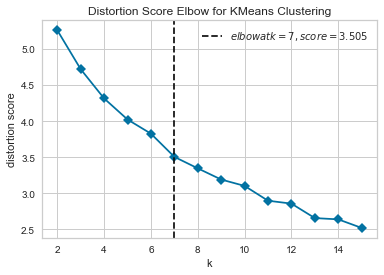

In [45]:
model_supercat = KElbowVisualizer(KMeans(random_state=0), k=15, timings=False)
model_supercat.fit(paris_grouped_clustering_supercat)
model_supercat.show()

In [46]:
# set number of clusters
kclusters = model_supercat.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering_supercat)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 1, 2, 0, 5, 2, 2, 5, 0, 1, 2, 2, 0, 0, 0, 2, 1, 0, 5, 1, 1, 1,
       0, 6, 1, 0, 2, 2, 1, 0, 3, 1, 2, 5, 0, 2, 5, 3, 2, 0, 2, 0, 0, 1,
       4, 1, 5, 2, 0, 0, 0, 0, 0, 0, 4, 1, 2, 1, 6, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 4, 5, 0, 0, 4, 4, 4, 4, 0, 0, 1, 4, 5, 0, 0, 2, 0, 1, 5,
       0, 0, 3, 0, 1, 1, 2, 3, 3, 3, 0])

In [47]:
# add clustering labels
neighborhoods_venues_sorted_supercat.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged_supercat = zip_paris

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged_supercat = paris_merged_supercat.join(neighborhoods_venues_sorted_supercat.set_index('Neighbourhood'), \
                                                   on='Name', how='right')

paris_merged_supercat # check the last columns!

,Name,Zip_Code,Latitude,Longitude,Department,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PARIS 04,75004,48.854228282,2.35736193814,75,4,Other Restaurant/Cafe,French Restaurant,Nature Site,Bar,Shop,European Restaurant,Oriental Restaurant,Cultural Site,Asian Restaurant,Hotel
1,PARIS 07,75007,48.8560825982,2.31243868773,75,4,French Restaurant,Other Restaurant/Cafe,Hotel,Nature Site,Historic Site,Bar,European Restaurant,American Restaurant,Asian Restaurant,Food & Drink Shop
2,PARIS 11,75011,48.8594154976,2.37874106024,75,4,Other Restaurant/Cafe,Bar,French Restaurant,European Restaurant,Asian Restaurant,Oriental Restaurant,Cultural Site,American Restaurant,Food & Drink Shop,Shop
4,PARIS 16,75116,48.8603987604,2.2620995594,75,0,French Restaurant,Other Restaurant/Cafe,Nature Site,Asian Restaurant,European Restaurant,Sports Site,Cultural Site,Transport,Hotel,Food & Drink Shop
5,PARIS 20,75020,48.8631867774,2.40081982673,75,4,Bar,French Restaurant,Other Restaurant/Cafe,Cultural Site,Food & Drink Shop,Asian Restaurant,Oriental Restaurant,European Restaurant,Shop,American Restaurant
6,BOIS COLOMBES,92270,48.9153368426,2.26738552597,92,1,Food & Drink Shop,Asian Restaurant,Other Restaurant/Cafe,Sports Site,French Restaurant,Hotel,Beauty,European Restaurant,Transport,Nature Site
7,BOULOGNE BILLANCOURT,92100,48.8365843138,2.23913599058,92,0,French Restaurant,Other Restaurant/Cafe,Asian Restaurant,European Restaurant,Shop,Oriental Restaurant,Food & Drink Shop,American Restaurant,Sports Site,Cultural Site
9,COURBEVOIE,92400,48.8984504771,2.25570587289,92,0,Hotel,Food & Drink Shop,French Restaurant,Asian Restaurant,Sports Site,European Restaurant,Other Restaurant/Cafe,Nature Site,Transport,Oriental Restaurant
10,LA GARENNE COLOMBES,92250,48.9067577111,2.24464604084,92,0,Asian Restaurant,French Restaurant,Other Restaurant/Cafe,Sports Site,Food & Drink Shop,European Restaurant,Bar,Transport,Nature Site,Office
11,LEVALLOIS PERRET,92300,48.895071672,2.28688268127,92,0,Other Restaurant/Cafe,Food & Drink Shop,French Restaurant,Shop,European Restaurant,Asian Restaurant,Hotel,American Restaurant,Bar,Sports Site


In [48]:
latitude = paris_merged_supercat.loc[paris_merged_supercat['Name']=='PARIS 01','Latitude'].astype(float)
longitude = paris_merged_supercat.loc[paris_merged_supercat['Name']=='PARIS 01','Longitude'].astype(float)

# create map
map_clusters = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged_supercat['Latitude'].astype(float), paris_merged_supercat['Longitude'].astype(float), \
                                  paris_merged_supercat['Name'], paris_merged_supercat['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [49]:
paris_merged_supercat.loc[paris_merged_supercat['Cluster Labels'] == 0, \
                     paris_merged_supercat.columns[[0] + list(range(5, paris_merged_supercat.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,PARIS 16,0,French Restaurant,Other Restaurant/Cafe,Nature Site,Asian Restaurant,European Restaurant,Sports Site,Cultural Site,Transport,Hotel,Food & Drink Shop
7,BOULOGNE BILLANCOURT,0,French Restaurant,Other Restaurant/Cafe,Asian Restaurant,European Restaurant,Shop,Oriental Restaurant,Food & Drink Shop,American Restaurant,Sports Site,Cultural Site
9,COURBEVOIE,0,Hotel,Food & Drink Shop,French Restaurant,Asian Restaurant,Sports Site,European Restaurant,Other Restaurant/Cafe,Nature Site,Transport,Oriental Restaurant
10,LA GARENNE COLOMBES,0,Asian Restaurant,French Restaurant,Other Restaurant/Cafe,Sports Site,Food & Drink Shop,European Restaurant,Bar,Transport,Nature Site,Office
11,LEVALLOIS PERRET,0,Other Restaurant/Cafe,Food & Drink Shop,French Restaurant,Shop,European Restaurant,Asian Restaurant,Hotel,American Restaurant,Bar,Sports Site
12,MALAKOFF,0,Asian Restaurant,Food & Drink Shop,European Restaurant,French Restaurant,Other Restaurant/Cafe,Nature Site,Transport,Cultural Site,Hotel,Sports Site
15,SEVRES,0,Other Restaurant/Cafe,Sports Site,Transport,Asian Restaurant,Food & Drink Shop,European Restaurant,French Restaurant,Nature Site,Hotel,Cultural Site
26,FONTENAY SOUS BOIS,0,Other Restaurant/Cafe,European Restaurant,Shop,Oriental Restaurant,Asian Restaurant,Hotel,Sports Site,American Restaurant,Bar,Food & Drink Shop
29,MAISONS ALFORT,0,Sports Site,Shop,Transport,Asian Restaurant,European Restaurant,French Restaurant,Food & Drink Shop,Office,Nature Site,Other Restaurant/Cafe
30,ST MANDE,0,Other Restaurant/Cafe,Asian Restaurant,French Restaurant,Sports Site,European Restaurant,Nature Site,Food & Drink Shop,American Restaurant,Bar,Transport


In [50]:
paris_merged_supercat.loc[paris_merged_supercat['Cluster Labels'] == 3, \
                     paris_merged_supercat.columns[[0] + list(range(5, paris_merged_supercat.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,VILLETANEUSE,3,Transport,Shop,Food & Drink Shop,Other Restaurant/Cafe,Sports Site,European Restaurant,American Restaurant,Asian Restaurant,Bar,Beauty
119,THIAIS,3,Shop,Transport,Other Restaurant/Cafe,Nature Site,Sports Site,Asian Restaurant,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site
130,VILLENEUVE LA GARENNE,3,Shop,Transport,Food & Drink Shop,Other Restaurant/Cafe,European Restaurant,Asian Restaurant,Nature Site,Hotel,Sports Site,Cultural Site
135,L ILE ST DENIS,3,Shop,Food & Drink Shop,Transport,Other Restaurant/Cafe,European Restaurant,Nature Site,Hotel,Sports Site,Cult Site,American Restaurant
147,FRESNES,3,Shop,Transport,Other Restaurant/Cafe,Food & Drink Shop,Asian Restaurant,Hotel,Sports Site,Cultural Site,American Restaurant,Bar
153,VILLIERS SUR MARNE,3,Transport,Shop,Other Restaurant/Cafe,Food & Drink Shop,Office,Sports Site,Cultural Site,American Restaurant,Asian Restaurant,Bar


The proposed clustering works just fine, but the clusters remain difficult to interpret. The above clustring does not take into account the total number of venues in each borough, however, when looking for a new place to live, this seems to be an important parameter to take into consideration. I thus propose to use a raw number of venues of each category instead of a proportion.

In [51]:
paris_sum = paris_onehot_supercat.groupby(['Neighbourhood']).sum().reset_index()
paris_sum.head()

,Neighbourhood,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,ALFORTVILLE,0,0,2,0,0,0,1,1,1,2,0,0,1,0,1,4,0,4,1,4
1,ANTONY,1,0,0,0,0,0,0,2,3,3,0,0,2,0,0,3,0,1,0,1
2,ARCUEIL,0,0,4,0,0,0,1,0,2,1,0,2,3,0,0,5,0,6,0,2
3,ASNIERES SUR SEINE,0,0,5,0,1,0,3,1,5,2,0,2,2,1,1,4,0,5,3,1
4,AUBERVILLIERS,0,0,0,0,0,0,1,0,2,2,0,0,3,0,0,2,0,1,5,2


In [52]:
paris_sum_clustering = paris_sum.drop(['Neighbourhood'], axis = 1)

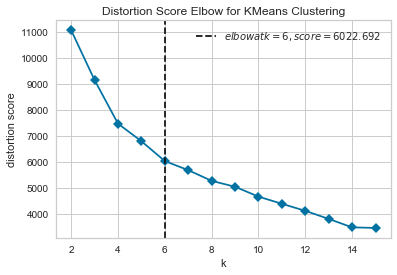

In [53]:
model_sum = KElbowVisualizer(KMeans(random_state=0), k=15, timings=False)
model_sum.fit(paris_sum_clustering)
model_sum.show()

This time, KElbowVisualizer does not encounter any problem finding an optimal number of clusters.

In [54]:
# set number of clusters
kclusters = model_sum.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_sum_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 5, 4, 4, 4, 1, 5, 1,
       5, 1, 4, 4, 0, 2, 3, 1, 4, 3, 3, 5, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3])

In [55]:
# add clustering labels
paris_sum.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged_sum = zip_paris

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged_sum = paris_merged_sum.join(paris_sum.set_index('Neighbourhood'), on='Name', how='right')

paris_merged_sum # check the last columns!

,Name,Zip_Code,Latitude,Longitude,Department,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,PARIS 04,75004,48.854228282,2.35736193814,75,4,0,1,4,12,0,1,6,8,0,15,1,3,13,0,6,19,0,10,1,0
1,PARIS 07,75007,48.8560825982,2.31243868773,75,1,0,3,3,6,0,0,1,6,3,30,7,11,10,0,0,20,0,0,0,0
2,PARIS 11,75011,48.8594154976,2.37874106024,75,4,0,4,6,16,0,0,5,11,4,13,0,1,2,0,5,28,0,3,2,0
4,PARIS 16,75116,48.8603987604,2.2620995594,75,3,0,0,5,1,0,0,3,5,2,11,1,2,9,0,1,10,0,0,5,3
5,PARIS 20,75020,48.8631867774,2.40081982673,75,3,0,1,3,16,0,1,4,2,3,9,1,1,1,1,2,7,0,1,1,0
6,BOIS COLOMBES,92270,48.9153368426,2.26738552597,92,0,0,0,3,0,1,0,0,1,10,2,0,1,1,0,0,3,0,1,3,1
7,BOULOGNE BILLANCOURT,92100,48.8365843138,2.23913599058,92,1,0,4,14,2,1,0,4,14,5,20,0,0,2,1,6,17,0,6,4,0
9,COURBEVOIE,92400,48.8984504771,2.25570587289,92,3,0,1,6,1,0,0,2,5,8,7,0,8,5,1,2,5,0,0,6,3
10,LA GARENNE COLOMBES,92250,48.9067577111,2.24464604084,92,0,0,0,7,1,0,0,0,2,3,5,0,0,1,1,1,4,0,1,3,1
11,LEVALLOIS PERRET,92300,48.895071672,2.28688268127,92,5,0,5,7,5,0,0,1,8,14,13,0,6,4,0,4,19,0,9,5,0


In [56]:
latitude = paris_merged_sum.loc[paris_merged_sum['Name']=='PARIS 01','Latitude'].astype(float)
longitude = paris_merged_sum.loc[paris_merged_sum['Name']=='PARIS 01','Longitude'].astype(float)

# create map
map_clusters = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged_sum['Latitude'].astype(float), paris_merged_sum['Longitude'].astype(float), \
                                  paris_merged_sum['Name'], paris_merged_sum['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Exploring the obtained clusters one by one
Cluster 0 (red) delineates residential areas with lots of shops and supermarkets but fewer restaurants, bars and cafés.

In [57]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 0, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
6,BOIS COLOMBES,0,0,0,3,0,1,0,0,1,10,2,0,1,1,0,0,3,0,1,3,1
10,LA GARENNE COLOMBES,0,0,0,7,1,0,0,0,2,3,5,0,0,1,1,1,4,0,1,3,1
13,RUEIL MALMAISON,0,0,0,0,1,0,0,0,0,4,3,1,1,2,0,0,0,0,0,1,1
14,SCEAUX,0,0,0,0,0,0,0,0,4,2,0,2,0,5,1,0,4,0,0,0,1
15,SEVRES,0,0,0,4,0,0,0,1,2,4,2,0,1,1,0,0,7,0,1,5,4
16,LE BOURGET,0,0,0,0,0,0,0,0,1,1,0,0,1,3,0,0,1,0,2,0,3
20,PANTIN,0,0,0,0,1,0,0,7,2,6,3,0,1,1,0,1,7,0,1,3,4
21,LES PAVILLONS SOUS BOIS,0,0,0,3,0,0,0,0,0,1,0,0,0,1,0,1,2,0,1,0,3
24,CHAMPIGNY SUR MARNE,0,0,0,0,0,0,0,0,0,4,2,0,1,0,0,0,2,0,2,1,1
26,FONTENAY SOUS BOIS,0,0,1,2,1,0,0,0,4,1,0,0,2,0,0,2,5,0,2,2,0


Cluster 1 (purple) is a truly gastronomic cluster: it has lots of French and European restaurants, as well as non-geographic types of restaurants.

In [58]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 1, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
1,PARIS 07,1,0,3,3,6,0,0,1,6,3,30,7,11,10,0,0,20,0,0,0,0
7,BOULOGNE BILLANCOURT,1,0,4,14,2,1,0,4,14,5,20,0,0,2,1,6,17,0,6,4,0
39,PARIS 05,1,0,3,8,7,1,0,7,11,5,18,2,4,5,0,4,20,0,4,1,0
40,PARIS 09,1,0,1,2,15,0,0,7,8,4,22,0,10,3,1,1,16,0,8,2,0
47,PARIS 17,1,0,3,3,4,0,0,2,17,5,25,0,9,4,0,6,20,0,1,1,0


Cluster 2 (blue) only has one district in it, and it is a curious one: it features 50 Asian restaurants.

In [59]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 2, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
36,PARIS 13,2,0,2,50,3,0,0,2,4,3,9,0,4,2,0,1,13,0,3,4,0


Cluster 3 (green) seems to have a bit of every type of venue, such a happy mean. It also geographically delineates the Paris boundary and corresponds to the respectful suburbs.

In [60]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 3, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
4,PARIS 16,3,0,0,5,1,0,0,3,5,2,11,1,2,9,0,1,10,0,0,5,3
5,PARIS 20,3,0,1,3,16,0,1,4,2,3,9,1,1,1,1,2,7,0,1,1,0
9,COURBEVOIE,3,0,1,6,1,0,0,2,5,8,7,0,8,5,1,2,5,0,0,6,3
12,MALAKOFF,3,0,0,10,1,1,0,3,7,9,6,0,2,4,0,1,6,0,2,2,4
30,ST MANDE,3,0,1,9,1,0,0,0,4,4,8,1,1,4,0,1,10,0,0,5,1
48,PARIS 19,3,0,0,1,12,0,0,9,4,4,10,0,5,9,0,1,7,0,0,2,1
68,VINCENNES,3,0,3,6,2,0,0,3,6,5,10,1,3,2,1,0,12,0,3,3,0
74,NEUILLY SUR SEINE,3,0,1,5,1,0,0,2,7,1,13,0,2,7,0,0,10,0,1,4,0
124,CLICHY,3,0,0,5,1,0,0,0,12,2,8,0,11,3,1,1,6,0,2,4,2
125,ISSY LES MOULINEAUX,3,0,1,9,0,0,0,1,5,6,16,0,7,6,0,1,13,0,4,8,5


Cluster 4 (yellow) is a night-life cluster.

In [61]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 4, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,PARIS 04,4,0,1,4,12,0,1,6,8,0,15,1,3,13,0,6,19,0,10,1,0
2,PARIS 11,4,0,4,6,16,0,0,5,11,4,13,0,1,2,0,5,28,0,3,2,0
37,PARIS 18,4,0,3,4,19,0,0,5,9,4,14,1,0,8,0,7,21,0,4,1,0
41,PARIS 10,4,0,2,13,7,0,0,0,11,8,8,0,4,2,0,11,28,0,4,2,0
42,PARIS 02,4,0,2,11,17,2,0,5,8,7,14,1,5,5,0,0,16,0,5,2,0
43,PARIS 03,4,0,5,8,9,1,0,10,4,2,7,0,4,3,0,6,30,0,11,0,0


Cluster 5 (orange) is my favourite one! In addition to French and non-geographic restaurants, has a lot of shops and natural sites, such as parks and gardens.

In [62]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 5, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,French Restaurant,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
11,LEVALLOIS PERRET,5,0,5,7,5,0,0,1,8,14,13,0,6,4,0,4,19,0,9,5,0
34,PARIS 06,5,0,2,2,6,0,0,2,3,7,15,2,8,13,0,3,23,0,13,1,0
38,PARIS 01,5,0,0,18,6,1,1,7,4,4,9,3,5,12,0,1,13,0,13,2,1
44,PARIS 08,5,0,1,2,4,2,0,8,3,3,16,3,19,8,0,0,10,0,20,1,0
102,PUTEAUX,5,0,1,7,3,0,0,1,6,9,9,0,4,13,0,4,20,0,16,5,2
